In [14]:
import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import datetime
import random
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error,r2_score,confusion_matrix
from sklearn.model_selection import KFold
from sklearn.preprocessing import MinMaxScaler
import pickle
pd.set_option('display.max_columns', 100)  # or 1000
pd.set_option('display.max_rows', 100)  # or 1000
import time
from numpy import concatenate

In [90]:
# Load testing dataset(Daily data)
def read_daily_test_df(features,file): # test_time = pd.Timestamp(yyyy,mm,dd)
    Lake_HydMet = pd.read_csv(file,header = 0,sep = '\t',parse_dates = ['Date'])
    Lake_HydMet = Lake_HydMet[features]
    #Lake_HydMet = Lake_HydMet[(Lake_HydMet['Date']>=test_time[0])&(Lake_HydMet['Date']<=test_time[1])].dropna()
    return Lake_HydMet

# Train and cross-validate the model
def training_cv(df,features,nutrient,year,loss_func):
    df['YY'] = df['Date'].apply(lambda d:d.year)
    features.append(nutrient)
    df = df[df['YY'].isin(year)][features].dropna()
    X_train = df.iloc[:,:-1]
    y_train = df.iloc[:,-1].values
    print('Number of samples: ' + str(len(y_train)))

    GBR = GradientBoostingRegressor(random_state=101)
    n_estimators = [int(x) for x in np.arange(40,140,20)]
    max_depth=[int(x) for x in np.arange(5,10,1)]
    learning_rate = [x for x in [0.01,0.1,1]]
    subsample = [x for x in [0.7,0.8,0.9,1]]
    param_grid = {'n_estimators': n_estimators,
                  'max_depth': max_depth,
                  'learning_rate':learning_rate,
                  'subsample':subsample}
    GBR_rs = RandomizedSearchCV(estimator = GBR,param_distributions = param_grid,n_iter = 30,cv = 5,verbose = 0)
    GBR_rs.fit(X_train,y_train)
    GBR.set_params(**GBR_rs.best_params_,random_state=101,loss=loss_func).fit(X_train,y_train)
    mae= -cross_val_score(GBR, X_train, y_train, cv=5,scoring = 'neg_mean_absolute_error')
    rmse = np.sqrt(-cross_val_score(GBR, X_train, y_train, cv=5,scoring = 'neg_mean_squared_error'))
    r2 = cross_val_score(GBR, X_train, y_train, cv=5,scoring = 'r2')
    print('Training dataset evaluation:')
    print("MAE %.2f (+/- %.2f)" % (mae.mean(), mae.std()))
    print("RMSE %.2f (+/- %.2f)" % (rmse.mean(), rmse.std()))
    print("R2 %.2f (+/- %0.2f)" % (r2.mean(), r2.std()))
    pickle.dump(GBR, open("GBR."+nutrient.split('(')[0]+".dat", "wb"))
    features.pop() 
    
# Make prediction with trained model
def predict(Erken_Nut,df,features,nutrient,test_time,ylim,Lake_Nut_metrics):
    #load the target GBR model
    GBR = pickle.load(open("GBR."+nutrient.split('(')[0]+".dat", "rb"))
    #predict yhat using test_X
    Erken_Nut[nutrient]=GBR.predict(Erken_Nut[features])
    Erken_Nut[nutrient]=Erken_Nut[nutrient].rolling(7,min_periods = 1,center=True).mean()
    nutrient_compare = Erken_Nut[['Date',nutrient]].merge(df[['Date',nutrient]].dropna(),
                                                          how = 'inner',on = 'Date')
    nutrient_compare.columns = ['Date','Prediction','True']
    Date = pd.DataFrame(pd.date_range(start = test_time[0],
                                      end = test_time[1]),
                    columns = ['Date'])
    #Erken_Nut_gap = Date.merge(Erken_Nut,how = 'left',on = 'Date')
    nutrient_compare=nutrient_compare[(nutrient_compare['Date']>=test_time[0])&(nutrient_compare['Date']<=test_time[1])]
    Lake_Nut_metrics[nutrient]['MAE']=mean_absolute_error(nutrient_compare['True'],
                                                          nutrient_compare['Prediction'])
    Lake_Nut_metrics[nutrient]['RMSE']=mean_squared_error(nutrient_compare['True'],
                                                          nutrient_compare['Prediction'],
                                                          squared = False)    
    Lake_Nut_metrics[nutrient]['R2']=r2_score(nutrient_compare['True'],
                                              nutrient_compare['Prediction'])
    return Erken_Nut[['Date',nutrient]],Lake_Nut_metrics

In [91]:
## Load training dataset
# Make sure you are in the main folder('..\Algal-bloom-prediction-machine-learning')
cd = os.getcwd()
print(cd)
while cd.split('\\')[-1]!='Algal-bloom-prediction-machine-learning':
    os.chdir('..')
    cd=os.getcwd()
    
os.chdir('Trainning data')
print('Load training data (containing nutrient observations)')
lakename = input('Lake name in short: ')
winter = input('Winter data or not? (Y/N)')
if winter =='Y':
    all_df = pd.read_csv(lakename+'_Observation_df.csv',sep = '\t',parse_dates = ['Date'])
else:
    all_df = pd.read_csv(lakename+'_Observation_df_nowinter.csv',sep = '\t',parse_dates = ['Date'])

C:\Users\shuli278\Documents\D\PDF_Uppsala\7-Python code of ML algorithm\GitHub\Algal-bloom-prediction-machine-learning\Algal-bloom-prediction-machine-learning\Scenario2\GBR
Load training data (containing nutrient observations)
Lake name in short: Mueggelsee
Winter data or not? (Y/N)N


In [107]:
## Specify the training year
year = all_df['Date'].apply(lambda d:d.year).unique()
print('Dataset contains years:{},in total {} years'.format(year,len(year)))#[2004,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016] 
num_trainingyr = int(input('Number of years for training:'))
training_yr = []
for i in range(num_trainingyr):
    yr = int(input('Training year:'))
    training_yr.append(yr)

Dataset contains years:[2004 2005 2006 2008 2009 2010 2011 2012 2013 2014 2016 2017],in total 12 years
Number of years for training:8
Training year:2004
Training year:2005
Training year:2006
Training year:2008
Training year:2009
Training year:2010
Training year:2011
Training year:2012


In [108]:
print(all_df.info())
n_feature = int(input('Number of daily features used for training: '))
features = ['Date']
for i in range(n_feature):
    f = input('Feature:')
    features.append(f)
print(features)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 426 entries, 0 to 425
Data columns (total 22 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   Date                   426 non-null    datetime64[ns]
 1   thermD                 426 non-null    float64       
 2   delT                   426 non-null    float64       
 3   U                      426 non-null    float64       
 4   AirP                   426 non-null    float64       
 5   Hum                    426 non-null    float64       
 6   AirT                   426 non-null    float64       
 7   SWR                    426 non-null    float64       
 8   CC                     426 non-null    float64       
 9   Prec                   426 non-null    float64       
 10  Ice_d                  426 non-null    float64       
 11  days from iceoff date  426 non-null    float64       
 12  MM                     426 non-null    int64         
 13  MLD  

In [109]:
test_time = [pd.Timestamp(int(input('test starts in year:')),1,1),
             pd.Timestamp(int(input('test ends in year:')),12,31)]

test starts in year:2013
test ends in year:2017


In [96]:
Nut_num = int(input('How many nutrients to predict? (include Chl and put them in order) '))
Nut=[]
for i in range(Nut_num):
    Nut.append(input('Nut_'+str(i+1)+': '))

How many nutrients to predict? (include Chl and put them in order) 5
Nut_1: NO3
Nut_2: SRP
Nut_3: TotP
Nut_4: NH4
Nut_5: Chl


In [52]:
features.insert(0,'Date')

In [110]:
Lake_Nut_metrics = pd.DataFrame(columns = Nut,index=['MAE','RMSE','R2'])
Lake_Nut=pd.DataFrame(columns = ['Date'])

In [57]:
features.pop()

'NO3'

In [111]:
os.chdir(cd+'\\Trainning data')
if winter =='Y':
    file = lakename+'_Daily_Observation_df.csv'
else:
    file = lakename+'_Daily_Observation_df_nowinter.csv'

testing_daily_df = read_daily_test_df(features,file) 

loss_func='huber'
features.pop(0)
start_time = time.time()
for j in range(Nut_num): 
    if j!=0:
        features.append(Nut[j-1]) 
    nutrient=Nut[j]
    print(nutrient)    
    if j==0:
        model = training_cv(all_df,features,nutrient,training_yr,loss_func)
    else:
        model = training_cv(testing_daily_df.merge(all_df[['Date']+[nutrient]],on='Date',how='outer')
                            ,features,nutrient,training_yr,loss_func)
    ylim = (0,all_df[Nut[j]].max())
    Model,Lake_Nut_metrics = predict(testing_daily_df,all_df,
                                          features,nutrient,test_time,
                                          ylim,Lake_Nut_metrics)
    Lake_Nut =Lake_Nut.merge(Model,on=['Date'],how='outer')
    print('\n')

print('Model takes '+str(round((time.time()-start_time)/60))+' min to run')
#Erken_Nut = testing_daily_df.merge(NOX_Model,on = 'Date',how = 'left')

NO3
Number of samples: 280
Training dataset evaluation:
MAE 0.13 (+/- 0.05)
RMSE 0.20 (+/- 0.07)
R2 0.34 (+/- 0.24)


SRP
Number of samples: 281
Training dataset evaluation:
MAE 50.62 (+/- 21.01)
RMSE 72.94 (+/- 34.93)
R2 0.31 (+/- 0.18)


TotP
Number of samples: 281
Training dataset evaluation:
MAE 36.50 (+/- 10.80)
RMSE 55.80 (+/- 22.60)
R2 0.66 (+/- 0.09)


NH4
Number of samples: 281
Training dataset evaluation:
MAE 0.05 (+/- 0.01)
RMSE 0.08 (+/- 0.03)
R2 0.14 (+/- 0.18)


Chl
Number of samples: 281
Training dataset evaluation:
MAE 17.06 (+/- 2.93)
RMSE 22.06 (+/- 5.34)
R2 -0.21 (+/- 0.31)


Model takes 3 min to run


In [112]:
Lake_Nut_metrics

,NO3,SRP,TotP,NH4,Chl
MAE,0.156378,30.557977,56.138895,0.043626,15.318939
RMSE,0.241014,35.242099,68.925126,0.072434,17.220972
R2,0.254986,-0.155054,-2.924639,-0.071109,-1.004574


In [113]:
os.chdir(cd+'\\Scenario2\\GBR')
Lake_Nut[(Lake_Nut['Date']>=test_time[0])&(Lake_Nut['Date']<=test_time[1])].to_csv(lakename+'_GBR predicted nutrient and Chl.csv',index = False)
Lake_Nut_metrics.to_csv(lakename+'_GBR_metrics.csv',index=False)

Threshold of delta_Chl:2
Threshold of Chl:10
Name of Chl variable: Chl


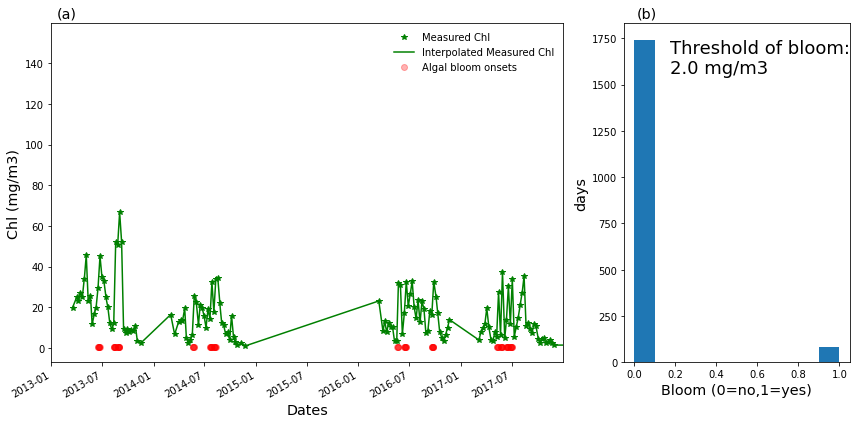

In [114]:
# Use the delta_Chl threshold to find the onset dates of algal bloom
threshold1 = float(input('Threshold of delta_Chl:'))
threshold2 = float(input('Threshold of Chl:'))
def find_bloom(x):
    if (x['delta_Chl']>threshold1)&(x[Chl_name]>threshold2):
        return 1
    else:
        return 0

Chl_name=input('Name of Chl variable: ')
OB=all_df[['Date',Chl_name]]
OB=OB[~OB['Date'].duplicated()]
OB_int = OB.set_index('Date').reindex(pd.date_range(start = test_time[0],end = test_time[1],freq = '1D')).interpolate(method = 'linear')
OB_int = OB_int.reset_index()
OB_int.columns = ['Date','Chl']
OB_int['Date'] = OB_int['Date'].apply(lambda d:d.date())
OB_int['Date'] = pd.to_datetime(OB_int['Date'])
# Use the delta_Chl threshold to find the onset dates of algal bloom
OB_int['delta_Chl'] = np.diff(OB_int['Chl'],append=0)
OB_int['Bloom'] = OB_int.apply(lambda x: find_bloom(x), axis=1) 
OB_bloom = OB_int[['Date','Bloom']]

fig=plt.figure(tight_layout='pad',figsize = (12,6))

gs = fig.add_gridspec(1, 3)
ax1 = fig.add_subplot(gs[0, :-1])
ax2 = fig.add_subplot(gs[0, -1])
OB_bloom['Bloom'].hist(grid=False,ax=ax2)
OB.plot(x = 'Date',y = Chl_name,style = 'g*',ax=ax1,label='Measured Chl')
OB_int.plot(x = 'Date',y = 'Chl',style = 'g-',ax=ax1,label='Interpolated Measured Chl')
ax1.plot(OB_bloom[OB_bloom['Bloom']==1]['Date'],
         OB_bloom[OB_bloom['Bloom']==1]['Bloom']*0.5,'ro',alpha=0.3,label='Algal bloom onsets')
ax1.legend(loc=0,frameon=False)
ax1.set_xlabel('Dates')
ax1.set_ylabel('Chl (mg/m3)')
ax1.set_xlim(test_time[0],test_time[1])
ax1.set_title('(a)',x=0.03)
ax2.set_xlabel('Bloom (0=no,1=yes)')
ax2.set_ylabel('days')
ax2.set_title('(b)',x=0.1)
fig.text(0.78,0.9,'Threshold of bloom: \n'+str(threshold1)+' mg/m3',fontsize=18,
         horizontalalignment='left',
         verticalalignment='top')
plt.rcParams.update({'axes.titlesize': 'x-large','axes.labelsize': 'x-large'})
fig.savefig(lakename+'_Chl observation and bloom dates.png',dpi=300)

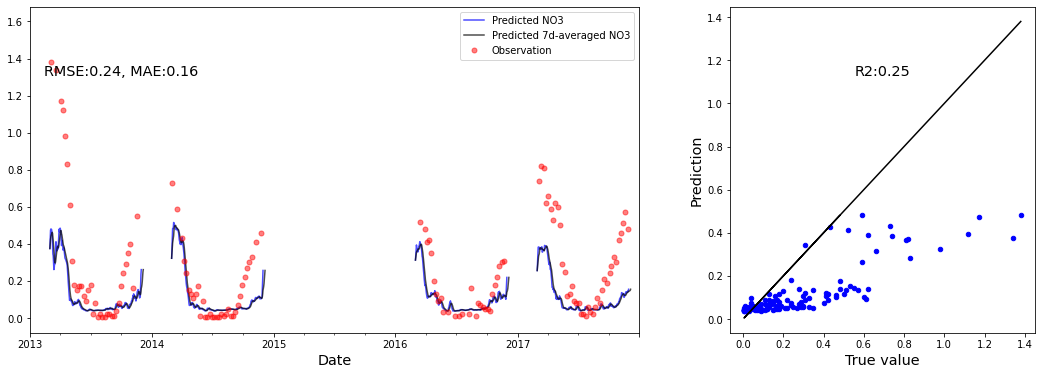

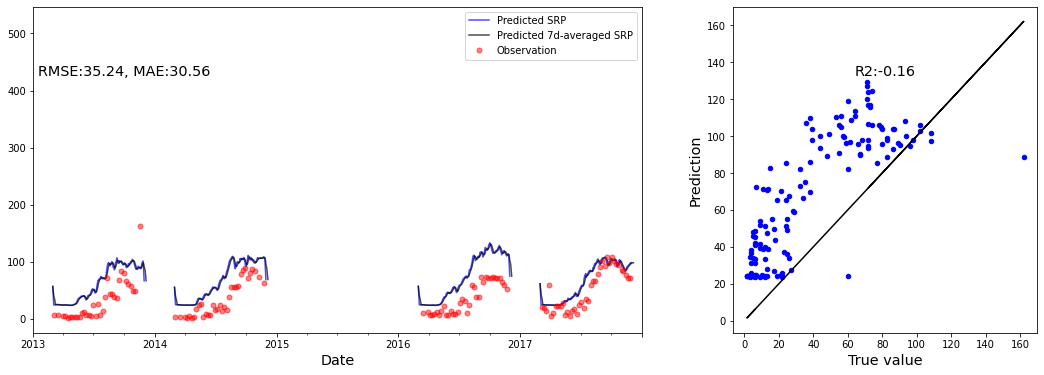

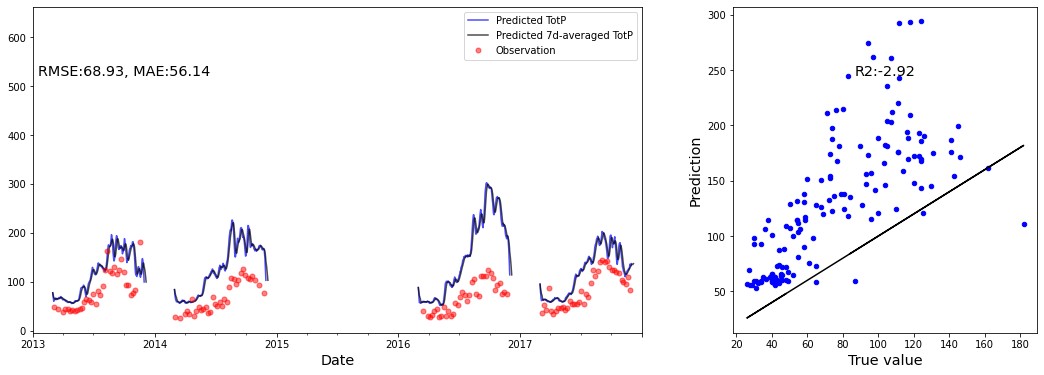

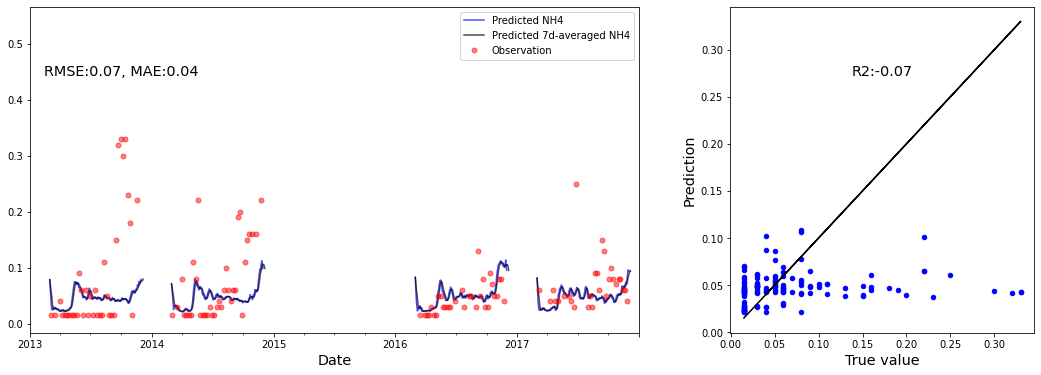

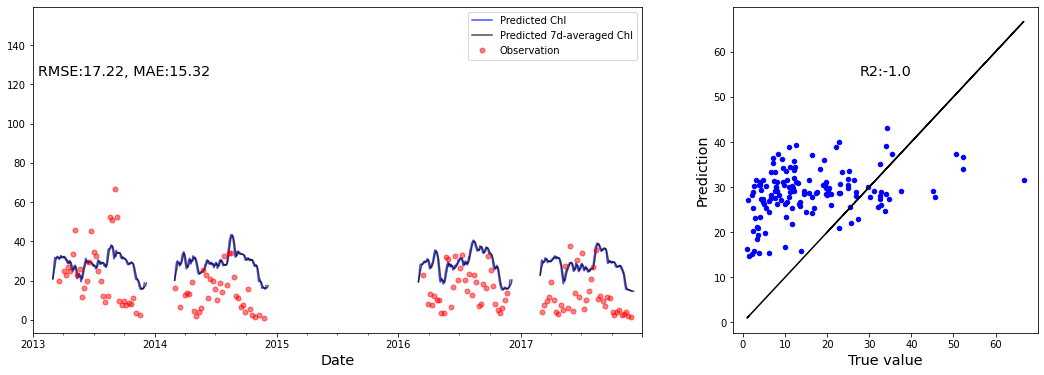

In [115]:
#os.chdir(cd+'\\Work record\\2-Pre-generated nutrients scenario\\GBR')
for k in range(Nut_num):
    nutrient_compare = Lake_Nut[['Date',Nut[k]]].merge(all_df[['Date',Nut[k]]],
                                                          how = 'inner',on = 'Date').dropna()
    nutrient_compare.columns = ['Date','Prediction','True']
    nutrient_compare=nutrient_compare[(nutrient_compare['Date']<test_time[1])&(nutrient_compare['Date']>test_time[0])]
    Date = pd.DataFrame(pd.date_range(start = test_time[0],
                                  end = test_time[1]),
                    columns = ['Date'])
    Lake_Nut_gap = Date.merge(Lake_Nut,how = 'left',on = 'Date')
 
    RMSE = mean_squared_error(nutrient_compare['True'],nutrient_compare['Prediction'],squared=False)
    MAE = mean_absolute_error(nutrient_compare['True'],nutrient_compare['Prediction'])
    #plot time-series comparison
    f1,ax2 = plt.subplots(1,2,figsize = (18,6),gridspec_kw={'width_ratios': [2, 1]})
    Lake_Nut_gap.plot(x = 'Date',y =Nut[k],c = 'b',ax = ax2[0],alpha=0.7,label = 'Predicted '+Nut[k])
    Lake_Nut_gap[Nut[k]] = Lake_Nut_gap[Nut[k]].rolling(7,min_periods = 1).mean()
    Lake_Nut_gap.plot(x = 'Date',y =Nut[k],c = 'k',ax = ax2[0],alpha=0.7,
                      label = 'Predicted 7d-averaged '+Nut[k])
    all_df[['Date',Nut[k]]].plot(x = 'Date',y =Nut[k],style = 'ro',ms = 5,alpha = 0.5,ax = ax2[0],
                       label = 'Observation')

    ax2[0].text(0.15, 0.8, 'RMSE:{}, MAE:{}'.format(round(RMSE,2),round(MAE,2)), 
            horizontalalignment='center',verticalalignment='center', 
            transform=ax2[0].transAxes,fontsize='x-large')

    ax2[0].set_xlim((test_time[0],test_time[1]))
    #ax2[0].set_ylim(Lake_Nut[Nut[k]].min(),Lake_Nut[Nut[k]].max())

    R2 = r2_score(nutrient_compare['True'],nutrient_compare['Prediction'])
    #plot scatter plot
    ax2[1].scatter(nutrient_compare['True'],nutrient_compare['Prediction'],s = 20,c = 'blue')
    ax2[1].plot(nutrient_compare['True'],nutrient_compare['True'],lw  =1.5,color = 'black')    
    ax2[1].set_xlabel('True value')
    ax2[1].set_ylabel('Prediction')
    ax2[1].text(0.5, 0.8, 'R2:{}'.format(round(R2,2)), 
            horizontalalignment='center',verticalalignment='center', 
            transform=ax2[1].transAxes,fontsize='x-large')
    f1.savefig(lakename+'_GBR_'+Nut[k]+'.png',dpi = 500)

In [116]:
OB['YY']=OB['Date'].apply(lambda d:d.year)
yy=OB['YY'].unique()
sam_int=[]
for i in range(len(yy)):
    sam_int.append(OB[OB['YY']==yy[i]]['Date'].diff().mean().days)
print('Averaged sample interval: {}'.format(round(np.nanmean(sam_int))))

Averaged sample interval: 7


In [117]:
sample_interval=int(input('Sample interval: ')) # 7
rolling_interval=int(input('Rolling interval: '))
rolling_threshold=float(input('Rolling bloom threshold: '))

ML_Chl = Lake_Nut[['Date',Chl_name]]
ML_Chl[Chl_name]=ML_Chl[Chl_name].rolling(sample_interval,min_periods = 1).mean()
ts=pd.DataFrame(pd.date_range(start=ML_Chl['Date'].iloc[0],
                              end=ML_Chl['Date'].iloc[-1],
                              freq='D'),
                columns=['Date'])
ML_Chl=ts.merge(ML_Chl,on='Date',how='left')
ML_Chl['delta_Chl'] = np.diff(ML_Chl[Chl_name],append = 0)

ML_Chl['Bloom'] = ML_Chl.apply(lambda x: find_bloom(x),axis=1)
ML_bloom = ML_Chl[['Date','Bloom']]
ML_bloom['rolling_bloom']=ML_bloom['Bloom'].rolling(rolling_interval,
                                                      center=False,
                                                      closed='both').mean().apply(lambda x: 1 if x>=rolling_threshold else 0)
# Find the model hits the events or not
Event_detection = OB_bloom.merge(ML_bloom[['Date','rolling_bloom']],how = 'inner',on = 'Date')
Event_detection.columns = ['Date','OB','ML']

tn, fp, fn, tp=confusion_matrix(Event_detection['OB'],Event_detection['ML']).ravel() 
(tn, fp, fn, tp)
TPR=tp/(tp+fn)
FPR=fp/(fp+tn)
accuracy=(tn+tp)/(tn+tp+fn+fp)
precision=tp/(tp+fp)
prevalence=(fn+tp)/(tn+tp+fn+fp)
f1=tp/(tp+0.5*(fp+fn))
pe=((tp+fp)/(tn+tp+fn+fp)*(fn+tn)/(tn+tp+fn+fp))+((tp+fn)/(tn+tp+fn+fp)*(fp+tn)/(tn+tp+fn+fp))
kappa=(accuracy-pe)/(1-pe)

print('GBR model')
print('TPR: {},\nFPR: {}, \naccuracy: {}, \nprecision: {}, \nprevalence: {},\nf1: {}, \nkappa:{}.'.format(round(TPR,2),
                                                                                                          round(FPR,2),
                                                                                                          round(accuracy,2),
                                                                                                          round(precision,2),
                                                                                                          round(prevalence,2),
                                                                                                          round(f1,2),
                                                                                                          round(kappa,2)))

Metrics=pd.DataFrame({'TPR':[TPR],'FPR':[FPR],'Accuracy': [accuracy],'Precision':[precision],
             'prevalence':[prevalence],'F1':[f1],'Kappa':[kappa]},index=['ML'])

Sample interval: 7
Rolling interval: 3
Rolling bloom threshold: 0.01
GBR model
TPR: 0.0,
FPR: 0.0, 
accuracy: 0.95, 
precision: nan, 
prevalence: 0.05,
f1: 0.0, 
kappa:0.95.


C:\Users\shuli278\AppData\Local\Temp/ipykernel_17816/3445678846.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ML_Chl[Chl_name]=ML_Chl[Chl_name].rolling(sample_interval,min_periods = 1).mean()
C:\Users\shuli278\AppData\Local\Temp/ipykernel_17816/3445678846.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ML_bloom['rolling_bloom']=ML_bloom['Bloom'].rolling(rolling_interval,
C:\Users\shuli278\AppData\Local\Temp/ipykernel_17816/3445678846.py:28: RuntimeWarning: invalid value encountered in longlong_sc

Text(0, 0.5, '(%)')

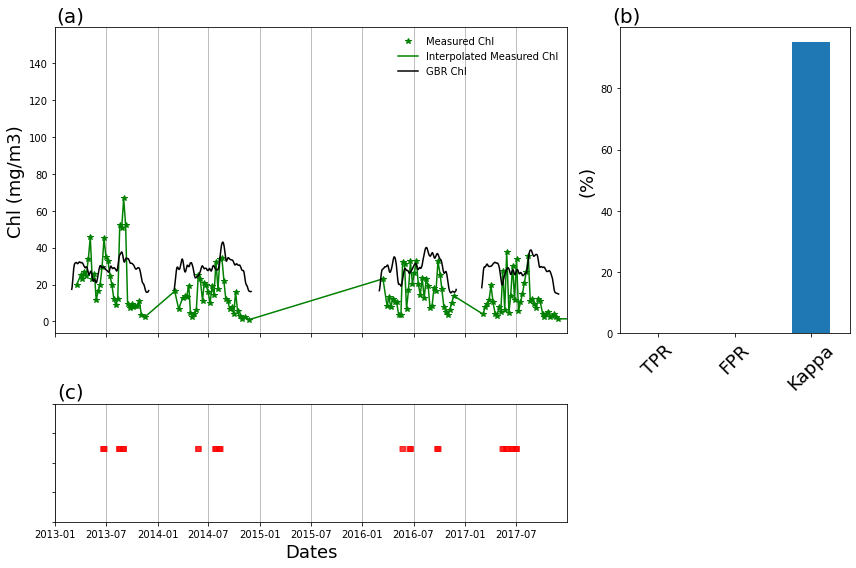

In [118]:
fig=plt.figure(tight_layout='True',figsize = (12,8))
gs = fig.add_gridspec(3, 3)
ax1 = fig.add_subplot(gs[0:2, :-1])
ax2 = fig.add_subplot(gs[2, :-1])

ax3 = fig.add_subplot(gs[0:2, -1])

OB.plot(x = 'Date',y = Chl_name,style = 'g*',ax=ax1,label='Measured Chl')
OB_int.plot(x = 'Date',y = 'Chl',style = 'g-',ax=ax1,label='Interpolated Measured Chl')
ML_Chl.plot(x = 'Date',y = Chl_name,style = 'k',ax=ax1,label='GBR Chl')
ax2.plot(OB_bloom[OB_bloom['Bloom']==1]['Date'],
         OB_bloom[OB_bloom['Bloom']==1]['Bloom']*0.5,'rs',alpha=0.3,markersize=5,
         label='Observed algal bloom onsets')
ax2.plot(ML_bloom[ML_bloom['Bloom']==1]['Date'],
         ML_bloom[ML_bloom['Bloom']==1]['Bloom']*0.5-0.3,'ks',alpha=0.3,markersize=5,
         label='Predicted algal bloom onsets')
ax1.legend(loc=0,frameon=False)
ax1.set_xlabel(' ')
ax1.set_xticklabels([])
ax1.set_ylabel('Chl (mg/m3)',fontsize=18)
ax1.set_xlim(test_time[0],test_time[1])
ax1.set_title('(a)',x=0.03,fontsize=20)
ax2.set_xlim(test_time[0],test_time[1])
ax2.set_ylabel(' ')
ax2.set_ylim(0,0.8)
ax2.set_yticklabels([])
ax2.set_xlabel('Dates',fontsize=18)
ax2.set_title('(c)',x=0.03,fontsize=20)
ax1.grid(axis='x')
ax2.grid(axis='x')

(Metrics[['TPR','FPR','Kappa']]*100).T.plot(kind='bar',ax=ax3)
ax3.legend('',frameon=False)
ax3.set_xticklabels(['TPR','FPR','Kappa'],rotation=45,fontsize=18)
ax3.set_title('(b)',x=0.03,fontsize=20)
ax3.set_ylabel('(%)',fontsize=18)

In [119]:
fig.savefig(lakename+'_GBR_Chl_bloom time.png',dpi = 500)

In [120]:
os.getcwd()

'C:\\Users\\shuli278\\Documents\\D\\PDF_Uppsala\\7-Python code of ML algorithm\\GitHub\\Algal-bloom-prediction-machine-learning\\Algal-bloom-prediction-machine-learning\\Scenario2\\GBR'